In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from los_functions_v2 import *
warnings.filterwarnings('ignore')

In [76]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_shap_scatter(shap_df, variable_name):
    """
    Create a scatter plot with SHAP values.

    Parameters:
    - shap_df: DataFrame with 'raw_value' and 'shap_value' columns.
    - variable_name: The name of the variable to include in the x-axis label and plot title.
    """
    # Define the colormap with your specified colors
    colors = ['#1E88E5', '#FF0052']  # Blue to Red
    cmap = mcolors.LinearSegmentedColormap.from_list('blue_red', colors)

    # Define fixed values
    alpha = 1.0  # Fully opaque
    point_size = 10  # Much smaller size of the points
    xlabel = f'Raw Value ({variable_name})'
    ylabel = 'SHAP Value'
    title = f'SHAP Scatter Plot: {variable_name}'

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(
        shap_df['raw_value'], 
        shap_df['shap_value'], 
        c=shap_df['shap_value'], 
        cmap=cmap,
        alpha=alpha,
        s=point_size
    )
    plt.colorbar(label="SHAP value")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Example usage:
# plot_shap_scatter(shap_df, 'con_max_admit_order_to_consult_order_any_hrs')


In [2]:
#all hospitalized patients 
df_all = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/data/master_los.csv', index_col=[0])
df_all["viz_service_collapsed"] = df_all["viz_service_collapsed"].apply(map_med)

#discharged home
df_home = df_all[df_all["viz_disp_collapsed"] == "Home"].copy()

#hf patients
df_all = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/data/master_los.csv', index_col=[0])
df_hf = df_all[df_all["viz_drg"]=="heart failure & shock w mcc"].copy()

In [3]:
# Dictionary of data frames with their names
dfs = {
    "df_all": df_all,
    "df_home": df_home,
    "df_hf":df_hf
}

fp_simple = '/gpfs/milgram/project/rtaylor/imc33/LOS/data/features_los_simple.xlsx'
fp_complex = '/gpfs/milgram/project/rtaylor/imc33/LOS/data/features_los.xlsx'
fp_continuous = '/gpfs/milgram/project/rtaylor/imc33/LOS/data/features_los_continuous.xlsx'
output_folder = '/gpfs/milgram/project/rtaylor/imc33/LOS/output'

In [4]:
X_train_preprocessed, X_val_preprocessed, y_train, y_val = preprocess_continuous_features(fp_continuous, df_all)
X_train_selected, X_val_selected = select_features(X_train_preprocessed, X_val_preprocessed, y_train)
model_xgb = run_xgb_tune_fit_1b(X_train_selected, y_train, num_eval=20)

df_filt shape: (12771, 912)
X train_preprocessed shape: (10246, 852)
X val preprocessed shape: (2525, 852)
y train prolonged LOS proportion: 0.4388053874682803
y val prolonged LOS proportion: 0.4304950495049505
X_train_selected shape: (10246, 369)
X_val_selected shape: (2525, 369)
100%|██████████| 20/20 [00:59<00:00,  2.98s/trial, best loss: -0.8887155155755455]
XGB Best parameters for 369 features: {'colsample_by_tree': 0.8099656297384077, 'learning_rate': 0.17383589279439982, 'max_depth': 7, 'n_estimators': 20, 'num_leaves': 8, 'reg_lambda': 0.48490437823738375}


In [5]:
np.random.seed(42)
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_val_selected)

In [37]:
variables = [
    'con_max_admit_order_to_consult_order_any_hrs',
    'con_max_consult_order_to_sign_any_hrs',
  #  'con_max_admit_order_to_consult_completion_any_hrs',
    'img_max_admit_order_to_imaging_order_any_hrs',
    'img_max_order_to_completion_any_hrs',
    'img_max_order_to_read_any_hrs',
    'img_max_admit_order_to_imaging_read_any_hrs'
]

In [38]:
X_val_raw = df_all.loc[X_val_selected.index, variables].fillna(0)

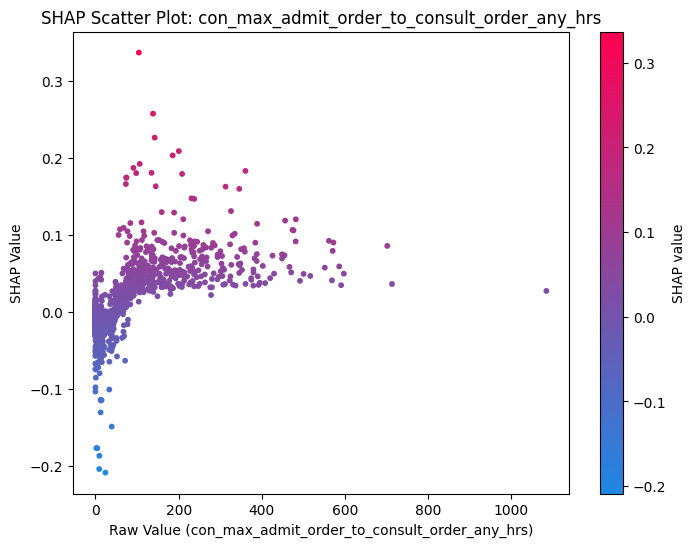

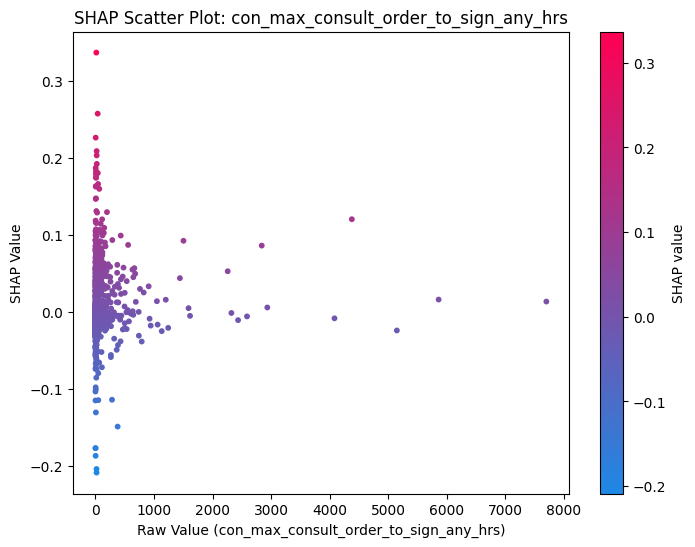

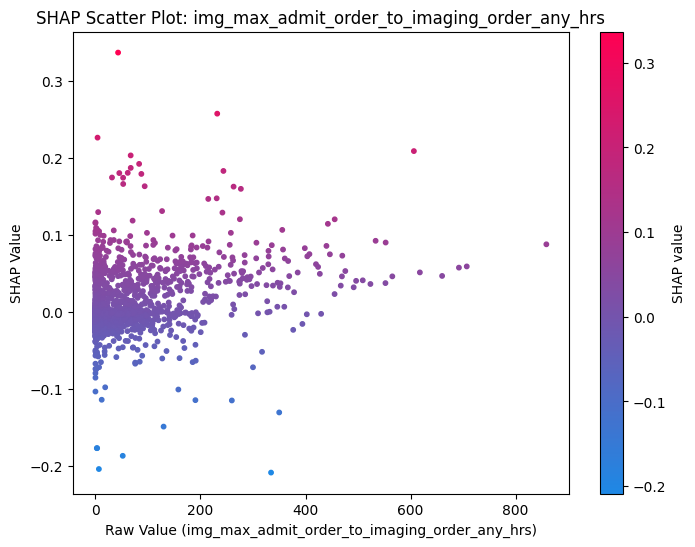

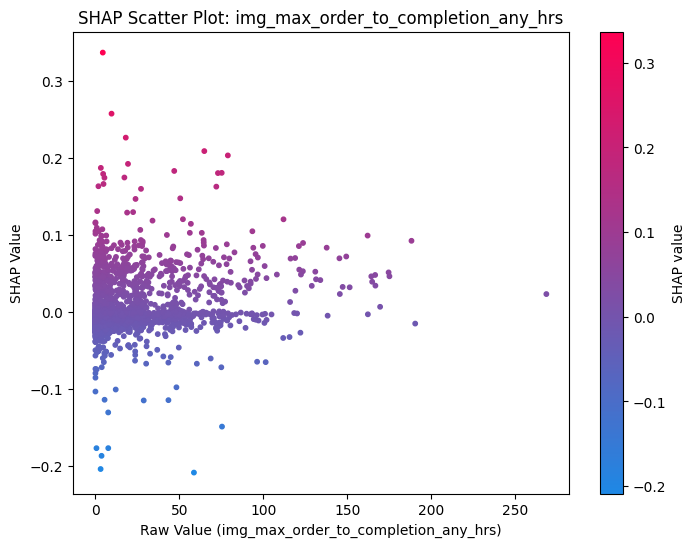

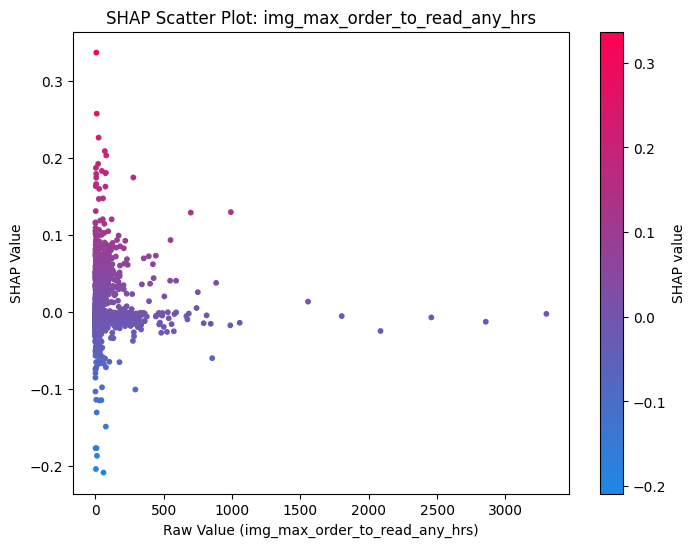

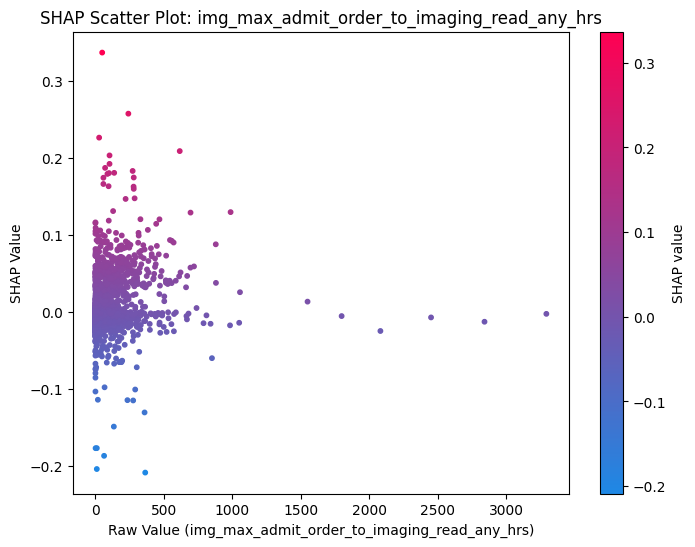

In [80]:
for var in variables:
    shap_df = pd.DataFrame({
        'shap_value': shap_value.values,
        'raw_value': X_val_raw[var].values
    }, index=X_val_raw.index)
    plot_shap_scatter(shap_df, var)